In [1]:
import torch
from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("mps")
print(f'Using {device} for inference')

Using mps for inference


In [2]:
import os

In [3]:
os.getcwd()

'/Users/krystianzielinski/Documents/repos/federated_learning_demo/notebooks'

In [4]:
os.chdir('/Users/krystianzielinski/Documents/repos/federated_learning_demo')

In [5]:
from lib.breast_segment import breast_segment

# Segmentation

In [7]:
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [8]:
from dotenv import load_dotenv
import os

In [9]:
from torchvision.utils import make_grid

In [10]:
from torch.utils.tensorboard import SummaryWriter

In [11]:
load_dotenv()

True

Utils

In [12]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
def get_data(input_path):
    norm = [0.5, 0.5, 0.5]

    data_transforms = {
        'train':
        transforms.Compose([
            transforms.Resize((250,250)),
            transforms.ToTensor(),
            transforms.Normalize(norm, norm)
        ]),
        'validation':
        transforms.Compose([
            transforms.Resize((250,250)),
            transforms.ToTensor(),
            transforms.Normalize(norm, norm)
        ]),
    }

    image_datasets = {
        'train': 
        datasets.ImageFolder(os.path.join(input_path,'train'), data_transforms['train']),
        'validation': 
        datasets.ImageFolder(os.path.join(input_path,'valid'), data_transforms['validation'])
    }

    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=64,
                                    shuffle=True),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=64,
                                    shuffle=False)
    }
    return dataloaders, image_datasets

In [14]:
from tqdm import tqdm

In [15]:
def train_model(model, criterion, optimizer, dataloaders, image_datasets,log_dir, num_epochs=3):
    tb = SummaryWriter(log_dir=log_dir)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            with tqdm(total=dataloaders[phase].dataset.samples.__len__()) as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)                    
                
                    pbar.update(labels.__len__())
            for name, weight in model.named_parameters():
                tb.add_histogram(name,weight, epoch)
                tb.add_histogram(f'{name}.grad',weight.grad, epoch)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            tb.add_scalar("Loss", epoch_loss, epoch)
            tb.add_scalar("Accuracy", epoch_acc, epoch)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    tb.close()
    return model

In [16]:
def eval_model(model, phase = 'validation'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    datasets_names = os.listdir(os.path.join(os.getenv('data_path'),'baza_student_raw'))
    for dataset_name in datasets_names:

        dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw',dataset_name))

        running_loss = 0.0
        running_corrects = 0
        with tqdm(total=dataloaders[phase].dataset.samples.__len__()) as pbar:
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)


                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                    
            
                pbar.update(labels.__len__())
        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print('Evaluating {} dataset. \n loss: {:.4f}, acc: {:.4f}'.format(dataset_name,
                                                    epoch_loss,
                                                    epoch_acc))

In [17]:
def eval_models(models_list, data_dir):
    phase = 'validation'
    datasets_names = os.listdir(os.path.join(os.getenv('data_path'),'baza_student_raw'))
    i=0
    for model in models_list:
        print(f'Using model trained on {datasets_names[i]}')
        eval_model(model)

        i=i+1

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Compare datasets

In [19]:
os.listdir(os.path.join(os.getenv('data_path'),'baza_student_raw'))

['.DS_Store',
 'vindr_four_classes_dark_augment',
 'bcd_four_classes',
 'ddsm_four_classes_augment',
 'abdul_four_classes_augment']

# ABDUL VINDR

In [13]:
model = models.resnet50(pretrained=True).to(device)
# model = models.vgg16(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [22]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','abdul_four_classes_augment'))

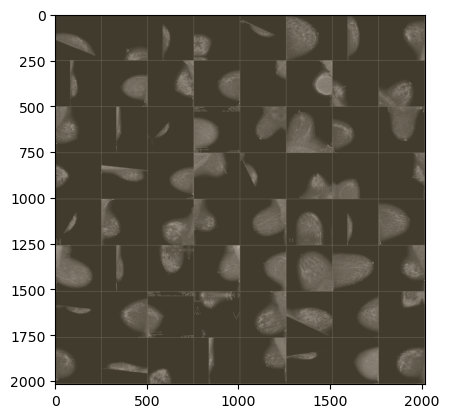

In [23]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid)

In [17]:
model_abdul = train_model(model, criterion, optimizer, dataloaders, image_datasets, filename_suffix='abdul', num_epochs=10)

Epoch 1/10
----------


  0%|          | 0/37701 [00:00<?, ?it/s]

In [ ]:
torch.save(model_abdul.state_dict(), 'models/model_abdul/weights.h5')

# CBIS

In [25]:
model = models.resnet50(pretrained=True).to(device)
# model = models.vgg16(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [26]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','cbis_ddsm_four_classes_augment'))

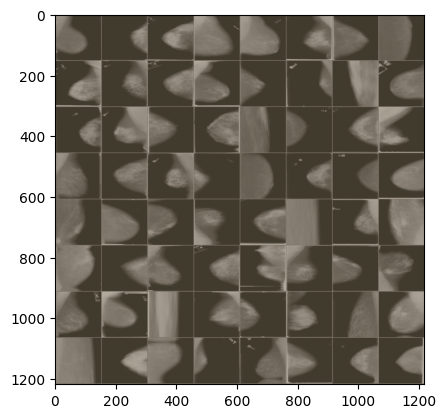

In [19]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid)

In [55]:
tb = SummaryWriter()
tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

In [27]:
import time

In [35]:
time.strftime("%Y-%m-%d %H:%M:%S")

'2023-01-06 13:39:38'

In [27]:
model_cbis = train_model(model, criterion, optimizer, dataloaders, image_datasets,log_dir = 'runs/cbis_v2_'+time.strftime("%Y-%m-%d"), num_epochs=10)

Epoch 1/10
----------


100%|██████████| 312/312 [01:45<00:00,  2.97it/s]


train loss: 1.4366, acc: 0.3205


100%|██████████| 54/54 [00:04<00:00, 13.26it/s]


validation loss: 1.2253, acc: 0.4074
Epoch 2/10
----------


100%|██████████| 312/312 [01:56<00:00,  2.67it/s]


train loss: 1.2301, acc: 0.4071


100%|██████████| 54/54 [00:04<00:00, 11.22it/s]


validation loss: 1.2995, acc: 0.3889
Epoch 3/10
----------


100%|██████████| 312/312 [01:55<00:00,  2.71it/s]


train loss: 1.0456, acc: 0.6282


100%|██████████| 54/54 [00:04<00:00, 11.84it/s]


validation loss: 1.2982, acc: 0.3333
Epoch 4/10
----------


100%|██████████| 312/312 [01:45<00:00,  2.96it/s]


train loss: 0.8846, acc: 0.7083


100%|██████████| 54/54 [00:04<00:00, 11.62it/s]


validation loss: 1.1149, acc: 0.5741
Epoch 5/10
----------


100%|██████████| 312/312 [01:40<00:00,  3.11it/s]


train loss: 0.7928, acc: 0.7724


100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


validation loss: 1.2311, acc: 0.3704
Epoch 6/10
----------


100%|██████████| 312/312 [01:37<00:00,  3.18it/s]


train loss: 0.7052, acc: 0.7788


100%|██████████| 54/54 [00:05<00:00, 10.69it/s]


validation loss: 1.0851, acc: 0.5741
Epoch 7/10
----------


100%|██████████| 312/312 [01:38<00:00,  3.17it/s]


train loss: 0.6500, acc: 0.8077


100%|██████████| 54/54 [00:04<00:00, 13.36it/s]


validation loss: 1.0417, acc: 0.5000
Epoch 8/10
----------


100%|██████████| 312/312 [01:38<00:00,  3.15it/s]


train loss: 0.5891, acc: 0.8237


100%|██████████| 54/54 [00:04<00:00, 13.16it/s]


validation loss: 1.2298, acc: 0.4259
Epoch 9/10
----------


100%|██████████| 312/312 [01:37<00:00,  3.21it/s]


train loss: 0.5048, acc: 0.8526


100%|██████████| 54/54 [00:04<00:00, 11.30it/s]


validation loss: 1.1235, acc: 0.5741
Epoch 10/10
----------


100%|██████████| 312/312 [01:36<00:00,  3.24it/s]


train loss: 0.4829, acc: 0.8365


100%|██████████| 54/54 [00:05<00:00, 10.72it/s]


validation loss: 1.4180, acc: 0.4259


In [28]:
torch.save(model_cbis.state_dict(), 'models/model_cbis/weights.h5')

# patch ddsm

In [20]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [21]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','patch_ddsm_four_classes_augment'))

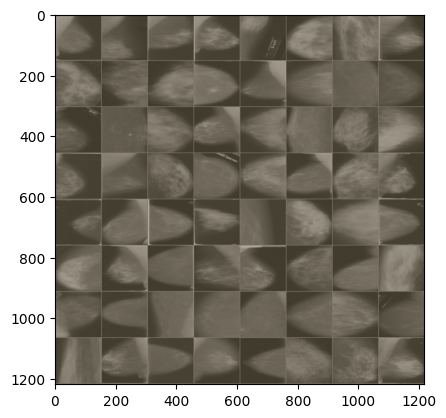

In [14]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid)

In [22]:
model_ddsm = train_model(model, criterion, optimizer, dataloaders, image_datasets, log_dir='runs/ddsm_v2_'+time.strftime("%Y-%m-%d"), num_epochs=10)

Epoch 1/10
----------


100%|██████████| 9924/9924 [52:07<00:00,  3.17it/s]


train loss: 0.9942, acc: 0.5600


100%|██████████| 1669/1669 [07:09<00:00,  3.89it/s]


validation loss: 0.9409, acc: 0.5830
Epoch 2/10
----------


100%|██████████| 9924/9924 [47:17<00:00,  3.50it/s]


train loss: 0.8598, acc: 0.6253


100%|██████████| 1669/1669 [05:44<00:00,  4.84it/s]


validation loss: 0.9694, acc: 0.5626
Epoch 3/10
----------


100%|██████████| 9924/9924 [45:23<00:00,  3.64it/s]


train loss: 0.8390, acc: 0.6384


100%|██████████| 1669/1669 [04:34<00:00,  6.08it/s]


validation loss: 0.9616, acc: 0.5776
Epoch 4/10
----------


100%|██████████| 9924/9924 [42:29<00:00,  3.89it/s]


train loss: 0.8237, acc: 0.6477


100%|██████████| 1669/1669 [04:35<00:00,  6.05it/s]


validation loss: 0.9916, acc: 0.5566
Epoch 5/10
----------


100%|██████████| 9924/9924 [41:27<00:00,  3.99it/s]


train loss: 0.8084, acc: 0.6531


100%|██████████| 1669/1669 [04:21<00:00,  6.37it/s]


validation loss: 0.9233, acc: 0.5962
Epoch 6/10
----------


100%|██████████| 9924/9924 [41:57<00:00,  3.94it/s]


train loss: 0.7879, acc: 0.6657


100%|██████████| 1669/1669 [05:10<00:00,  5.37it/s]


validation loss: 1.0292, acc: 0.5542
Epoch 7/10
----------


100%|██████████| 9924/9924 [45:31<00:00,  3.63it/s]


train loss: 0.7880, acc: 0.6644


100%|██████████| 1669/1669 [05:54<00:00,  4.71it/s]


validation loss: 0.9225, acc: 0.6010
Epoch 8/10
----------


100%|██████████| 9924/9924 [47:27<00:00,  3.48it/s]


train loss: 0.7738, acc: 0.6675


100%|██████████| 1669/1669 [05:03<00:00,  5.50it/s]


validation loss: 0.9058, acc: 0.6034
Epoch 9/10
----------


100%|██████████| 9924/9924 [48:32<00:00,  3.41it/s]


train loss: 0.7759, acc: 0.6667


100%|██████████| 1669/1669 [05:44<00:00,  4.84it/s]


validation loss: 1.0717, acc: 0.5249
Epoch 10/10
----------


100%|██████████| 9924/9924 [45:27<00:00,  3.64it/s]


train loss: 0.7730, acc: 0.6668


100%|██████████| 1669/1669 [05:06<00:00,  5.44it/s]


validation loss: 0.9316, acc: 0.5926


In [23]:
torch.save(model_ddsm.state_dict(), 'models/model_ddsm/weights.h5')

# VINDR

In [15]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [16]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_dark_augment'))

In [19]:
model_vindr = train_model(model, criterion, optimizer, dataloaders, image_datasets, log_dir='runs/vindr_v1_'+time.strftime("%Y-%m-%d"), num_epochs=10)

Epoch 1/10
----------


100%|██████████| 31678/31678 [2:26:50<00:00,  3.60it/s]  


train loss: 0.6639, acc: 0.7112


100%|██████████| 2539/2539 [06:18<00:00,  6.71it/s]


validation loss: 0.5278, acc: 0.7956
Epoch 2/10
----------


100%|██████████| 31678/31678 [2:14:21<00:00,  3.93it/s]  


train loss: 0.5737, acc: 0.7504


100%|██████████| 2539/2539 [05:41<00:00,  7.44it/s]


validation loss: 0.5368, acc: 0.7818
Epoch 3/10
----------


100%|██████████| 31678/31678 [2:27:25<00:00,  3.58it/s]  


train loss: 0.5391, acc: 0.7636


100%|██████████| 2539/2539 [09:23<00:00,  4.51it/s]


validation loss: 0.5135, acc: 0.7940
Epoch 4/10
----------


100%|██████████| 31678/31678 [2:34:38<00:00,  3.41it/s]  


train loss: 0.5178, acc: 0.7732


100%|██████████| 2539/2539 [06:20<00:00,  6.67it/s]


validation loss: 0.4907, acc: 0.8074
Epoch 5/10
----------


100%|██████████| 31678/31678 [2:18:08<00:00,  3.82it/s]  


train loss: 0.5098, acc: 0.7774


100%|██████████| 2539/2539 [05:55<00:00,  7.13it/s]


validation loss: 0.4917, acc: 0.8039
Epoch 6/10
----------


100%|██████████| 31678/31678 [2:18:08<00:00,  3.82it/s]  


train loss: 0.4894, acc: 0.7886


100%|██████████| 2539/2539 [06:08<00:00,  6.89it/s]


validation loss: 0.5228, acc: 0.8007
Epoch 7/10
----------


100%|██████████| 31678/31678 [2:17:58<00:00,  3.83it/s]  


train loss: 0.4786, acc: 0.7914


100%|██████████| 2539/2539 [05:53<00:00,  7.18it/s]


validation loss: 0.5206, acc: 0.7995
Epoch 8/10
----------


100%|██████████| 31678/31678 [2:17:35<00:00,  3.84it/s]  


train loss: 0.4675, acc: 0.7973


100%|██████████| 2539/2539 [06:08<00:00,  6.88it/s]


validation loss: 0.4905, acc: 0.8078
Epoch 9/10
----------


100%|██████████| 31678/31678 [2:18:42<00:00,  3.81it/s]  


train loss: 0.4533, acc: 0.8040


100%|██████████| 2539/2539 [05:57<00:00,  7.10it/s]


validation loss: 0.4761, acc: 0.8090
Epoch 10/10
----------


100%|██████████| 31678/31678 [2:32:23<00:00,  3.46it/s]  


train loss: 0.4500, acc: 0.8052


100%|██████████| 2539/2539 [06:10<00:00,  6.86it/s]


validation loss: 0.5198, acc: 0.8023


In [24]:
torch.save(model_vindr.state_dict(), 'models/model_vindr/weights.h5')

In [ ]:
!tensorboard --logdir runs

# Evaluation

## Abdul VINDR

In [43]:
model = models.resnet50(pretrained=True).to(device)
# model = models.vgg16(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)

In [44]:
model_abdul = model
model_abdul.load_state_dict(torch.load('models/model_abdul/weights.h5'))

<All keys matched successfully>

In [45]:
eval_model(model_abdul)

100%|██████████| 4233/4233 [11:29<00:00,  6.14it/s]


Evaluating abdul_cbis_vindr_bcd_four_classes_augment dataset. 
 loss: 0.6323, acc: 0.7449


100%|██████████| 54/54 [00:05<00:00, 10.44it/s]


Evaluating cbis_ddsm_four_classes_augment dataset. 
 loss: 1.2190, acc: 0.5370


100%|██████████| 1669/1669 [04:47<00:00,  5.80it/s]


Evaluating patch_ddsm_four_classes_augment dataset. 
 loss: 1.5208, acc: 0.4266


100%|██████████| 2539/2539 [06:54<00:00,  6.12it/s]


Evaluating vindr_four_classes_dark_augment dataset. 
 loss: 0.5117, acc: 0.8070


## VINDR

In [42]:
eval_model(model_vindr)

100%|██████████| 4233/4233 [26:34<00:00,  2.65it/s]


Evaluating abdul_cbis_vindr_bcd_four_classes_augment dataset. 
 loss: 1.6713, acc: 0.5939


100%|██████████| 54/54 [00:05<00:00, 10.06it/s]


Evaluating cbis_ddsm_four_classes_augment dataset. 
 loss: 3.0248, acc: 0.2778


100%|██████████| 1669/1669 [10:26<00:00,  2.66it/s]


Evaluating patch_ddsm_four_classes_augment dataset. 
 loss: 3.1261, acc: 0.3457


100%|██████████| 2539/2539 [13:34<00:00,  3.12it/s]


Evaluating vindr_four_classes_dark_augment dataset. 
 loss: 0.5198, acc: 0.8023


In [46]:
eval_model(model_ddsm)

100%|██████████| 4233/4233 [26:10<00:00,  2.70it/s]


Evaluating abdul_cbis_vindr_bcd_four_classes_augment dataset. 
 loss: 1.4331, acc: 0.4637


100%|██████████| 54/54 [00:19<00:00,  2.75it/s]


Evaluating cbis_ddsm_four_classes_augment dataset. 
 loss: 1.1631, acc: 0.5185


100%|██████████| 1669/1669 [10:38<00:00,  2.62it/s]


Evaluating patch_ddsm_four_classes_augment dataset. 
 loss: 0.9316, acc: 0.5926


100%|██████████| 2539/2539 [15:11<00:00,  2.79it/s]


Evaluating vindr_four_classes_dark_augment dataset. 
 loss: 1.2244, acc: 0.5573


In [47]:
eval_model(model_cbis)

100%|██████████| 4233/4233 [10:41<00:00,  6.60it/s]


Evaluating abdul_cbis_vindr_bcd_four_classes_augment dataset. 
 loss: 2.0566, acc: 0.1925


100%|██████████| 54/54 [00:05<00:00, 10.13it/s]


Evaluating cbis_ddsm_four_classes_augment dataset. 
 loss: 1.4180, acc: 0.4259


100%|██████████| 1669/1669 [04:51<00:00,  5.73it/s]


Evaluating patch_ddsm_four_classes_augment dataset. 
 loss: 1.9139, acc: 0.2810


100%|██████████| 2539/2539 [05:32<00:00,  7.64it/s]


Evaluating vindr_four_classes_dark_augment dataset. 
 loss: 2.4624, acc: 0.0764
